<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/19_4_EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В домашней работе вам необходимо, используя пример из урока 19.2 и Keras 3, произвести тонкую настройку модели второй версии EfficientNetV2 на примере набора данных Stanford Dogs.

Баллы за задание начисляются следующим образом:

3 балла - дается за успешно выполненное задание с точностью на проверочной выборке не менее 75%, в задании должна быть проведена аугментация данных.
Для получения 4-х баллов необходимо добиться, чтобы точности на проверочной и тестовой выборках были выше 75%.
Для получения 5-ти баллов необходимо случайным образом отобрать 10 пород собак, выполнить аугментацию и добиться точности как на обучающей, так и проверочной выборках более 85%.

In [1]:
import keras
print(keras.__version__)

3.4.1


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import EarlyStopping

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128

!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
!unzip -qo "stanford_dogs" -d ./dataset
IMAGE_PATH = './dataset/'

--2024-10-07 15:38:05--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  24.5MB/s    in 28s     

2024-10-07 15:38:34 (26.1 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [3]:
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


In [4]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE) # размер мини-батча

# Разделение на тестовый датасет
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

CLASS_LIST = sorted(os.listdir(IMAGE_PATH))
CLASS_COUNT = len(CLASS_LIST)
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Using 4114 files for validation.
Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 

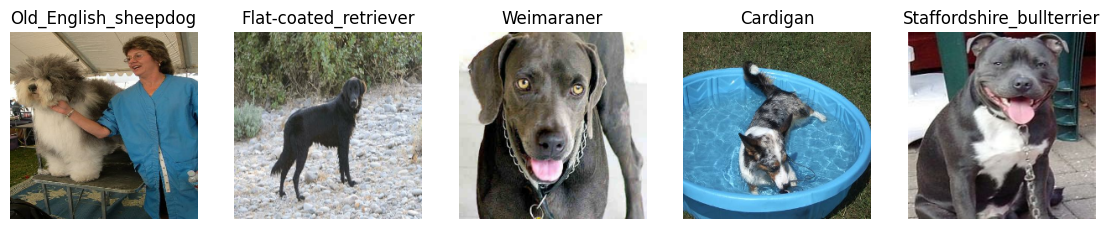

In [5]:
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1): # берем первый батч обучающей выборки
    for i in range(5): # отрисуем первые 16 картинок батча
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(keras.utils.img_to_array(images[i]).astype("uint8"))
        plt.title(CLASS_LIST[labels[i]]) # покажем метки
        plt.axis("off") # отключаем отображение осей

In [6]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness(factor=0.2)]

def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [7]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE,) # число потоков для обработки в map (автонастройка зависит от возможностей процессора)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE,) # число потоков для обработки в map (автонастройка зависит от возможностей процессора)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [8]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNetV2")
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    return model

Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1543s 12s/step - acc: 0.1587 - loss: 4.1921 - val_acc: 0.7885 - val_loss: 1.4889
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1515s 12s/step - acc: 0.4380 - loss: 2.1775 - val_acc: 0.8253 - val_loss: 0.6819
Epoch 3/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1522s 12s/step - acc: 0.4986 - loss: 1.9256 - val_acc: 0.8427 - val_loss: 0.5392
Epoch 4/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1580s 12s/step - acc: 0.5241 - loss: 1.7934 - val_acc: 0.8432 - val_loss: 0.5006
Epoch 5/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1514s 12s/step - acc: 0.5474 - loss: 1.7022 - val_acc: 0.8422 - val_loss: 0.4893
Epoch 6/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1520s 12s/step - acc: 0.5472 - loss: 1.6766 - val_acc: 0.8437 - val_loss: 0.5027
Epoch 7/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1520s 12s/step - acc: 0.5720 - loss: 1.5703 - val_acc: 0.8475 - val_loss: 0.4837
Epoch 8/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1522s 12s/step - acc: 0.5727 - loss: 1.5803 - val_acc: 0.8524 - val_loss: 0.4778
Epoch 9/15
129/129 ━━━━━━━━━━━━━

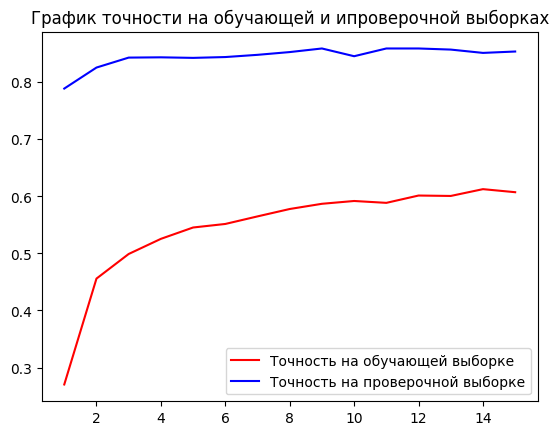

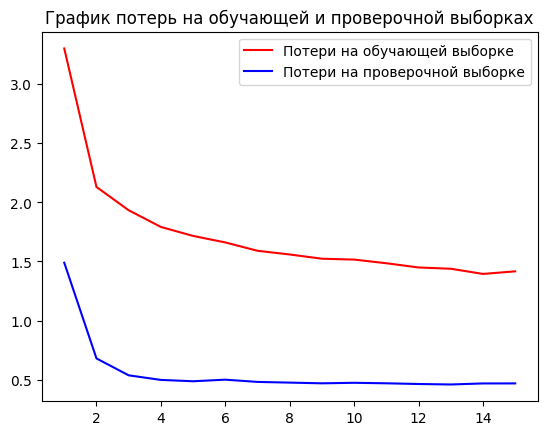

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
epochs = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)]

model = build_model(num_classes=CLASS_COUNT)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и ипроверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

show_plot(history)

model.save('best_model_pretrain.keras')

from google.colab import files
files.download('best_model_pretrain.keras')


In [9]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving best_model_pretrain.keras to best_model_pretrain.keras
User uploaded file "best_model_pretrain.keras" with length 18905289 bytes


In [10]:
model = keras.saving.load_model('best_model_pretrain.keras')

In [12]:
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])


unfreeze_model(model)

epochs = 10
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


test_ds = test_ds.map(
    lambda img, label: (tf.image.resize(img, IMAGE_SIZE), tf.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf.data.AUTOTUNE,).prefetch(tf.data.AUTOTUNE)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - acc: 0.6486 - loss: 1.2363 - val_acc: 0.8180 - val_loss: 0.6281
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - acc: 0.6519 - loss: 1.2100 - val_acc: 0.8209 - val_loss: 0.6255
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - acc: 0.6563 - loss: 1.2064 - val_acc: 0.8209 - val_loss: 0.6218
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - acc: 0.6625 - loss: 1.1714 - val_acc: 0.8214 - val_loss: 0.6202
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - acc: 0.6640 - loss: 1.1786 - val_acc: 0.8228 - val_loss: 0.6194
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - acc: 0.6732 - loss: 1.1576 - val_acc: 0.8228 - val_loss: 0.6179
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - acc: 0.6621 - loss: 1.1548 - val_acc: 0.8233 - val_loss: 0.6170
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - acc: 0.6781 - loss: 1.1283 - val_acc: 0.8233 - val_loss: 0.6165
Epoch 9/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/